## Extraction of Parameters from Volume Curves

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import InterpolatedUnivariateSpline

Read the data and construct a python dictionary from it indexed by participant number. Each entry will be a pandas dataframe with columns for LV and LA volumes and an index corresponding to the delay from trigger in milliseconds calculated by dividing the RR interval by the number of phases.

In [2]:
volumes = 'FullVolumes.xlsx'
rrintervals = 'RRIntervals.xlsx'

df_vols = pd.read_excel(volumes)
df_rrintervals = pd.read_excel(rrintervals).reset_index(drop=True)
df_rrintervals.index = ['RR']

df_la = df_vols.filter(regex='LA-[0-9]{3,3}$')
df_lv = df_vols.filter(regex='LV-[0-9]{3,3}$')
df_times = df_rrintervals.filter(regex='LV-[0-9]{3,3}$').T

nrows = df_la.count(axis=0)[0]
df_times['dT'] = df_times['RR'] / nrows
patients = {}
for patno in [int(col[-3:]) for col in df_la]:
    patients[patno] = pd.concat([
        pd.Series(np.arange(nrows) * df_times['dT']['LV-%d' % patno], name='Time'),
        df_lv['LV-%d' % patno],
        df_la['LA-%d' % patno],
    ], axis=1).set_index('Time')
    patients[patno].columns = ('LV', 'LA')
    patients[patno].pat_name = 'Patient %d' % patno

Example Dataset

In [3]:
patientno = 178

Functions to calculate the LV parameters

In [4]:
def lv_es_index(volumes):
    return np.argmin(volumes)

def lv_split_at_es(volumes):
    es = lv_es_index(volumes)
    return volumes[:es], volumes[es:]

def lv_vol_at_es(volumes):
    return volumes[lv_es_index(volumes)]

def lv_vol_at_ss(volumes):
    return volumes[0]

def lv_vol_at_ed(volumes):
    return volumes[-1]

def idx_nearest(array, value, after=0):
    return np.abs(array[after:]-value).argmin() + after

def lv_idx_for_refill80_full(volumes, use_vss=True):
    vss = lv_vol_at_ss(volumes)
    ves = lv_vol_at_es(volumes)
    ved = lv_vol_at_ed(volumes)
    
    fullvol = vss if use_vss else (vss + ved) / 2
    emptyvol = ves
    
    eighty_vol = 0.2*emptyvol + 0.8*fullvol
    return idx_nearest(volumes, value=eighty_vol, after=lv_es_index(volumes))

def lv_idx_max_systolic_down_slope(volumes, slopes):
    esi = lv_es_index(volumes)
    systolic_down_slopes = -slopes[:esi]
    return systolic_down_slopes.argmax()

def lv_idx_max_recovery_slopes(volumes, slopes):
    esi = lv_es_index(volumes)
    # need to further split into early and late.
    idx80 = lv_idx_for_refill80_full(volumes)
    
    diastolic_early_up_slopes = slopes[esi:idx80]
    diastolic_late_up_slopes = slopes[idx80:]
    idx_early = diastolic_early_up_slopes.argmax() + esi
    idx_late = diastolic_late_up_slopes.argmax() + idx80
    
    return idx_early, idx_late

Helper Functions for Plotting

In [5]:
def plot_tangent(point, slope, xmargin=60, axes=None):
    if axes is None:
        fig, axes = plt.subplots()
    x, y = point
    y0 = y - x * slope
    
    xlower, xupper = x-xmargin, x+xmargin
    ylower, yupper = y0 + xlower*slope, y0 + xupper*slope
    
    axes.plot([xlower, x, xupper], [ylower, y, yupper], linestyle='-', linewidth=1.5, marker='>', markersize=5)

Report Parameters of Ventricular Curve

In [6]:
def plot_lv_params(patient, region='LV'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 
    diffs = np.gradient(volume) / np.diff(time)[0]
    r_to_r = time[-1]
    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_msecs      = np.mean(np.diff(time))
    # one order higher for the derivative sounds right .. increase window to match
    sg_derivative = savgol_filter(x=volume, window_length=7, polyorder=3, deriv=1, delta=dt_msecs)

    spline = InterpolatedUnivariateSpline(time, sg_volume)
    spline_deriv = InterpolatedUnivariateSpline(time, sg_derivative)

    interpolated_time   = np.linspace(0, time[-1], len(time)*3)
    interpolated_savgol = spline(interpolated_time)
    interpolated_deriv  = spline_deriv(interpolated_time)

    min_vol_index = lv_es_index(interpolated_savgol)
    min_vol_time  = interpolated_time[min_vol_index]
    min_volume    = interpolated_savgol[min_vol_index]
    eighty_percent_idx = lv_idx_for_refill80_full(interpolated_savgol)
    eighty_percent_time = interpolated_time[eighty_percent_idx]
    eighty_percent_vol = interpolated_savgol[eighty_percent_idx]

    max_emptying_index = lv_idx_max_systolic_down_slope(interpolated_savgol, interpolated_deriv)
    max_emptying_time = interpolated_time[max_emptying_index]
    max_emptying_vol = interpolated_savgol[max_emptying_index]
    max_emptying_slope = interpolated_deriv[max_emptying_index]

    max_early_filling_index, max_late_filling_index = lv_idx_max_recovery_slopes(interpolated_savgol, interpolated_deriv)
    max_early_filling_time = interpolated_time[max_early_filling_index]
    max_late_filling_time = interpolated_time[max_late_filling_index]

    max_early_filling_vol = interpolated_savgol[max_early_filling_index]
    max_late_filling_vol = interpolated_savgol[max_late_filling_index]

    max_early_filling_slope = interpolated_deriv[max_early_filling_index]    
    max_late_filling_slope = interpolated_deriv[max_late_filling_index]    
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(time, volume, '.')
    ax[0].plot(interpolated_time, interpolated_savgol, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)    
    ax[0].scatter(
        [max_emptying_time, min_vol_time, max_early_filling_time, eighty_percent_time, max_late_filling_time],
        [max_emptying_vol, min_volume, max_early_filling_vol, eighty_percent_vol, max_late_filling_vol],
        s=1250, marker='+'
    )    
    
    plot_tangent((max_emptying_time, max_emptying_vol), slope=max_emptying_slope, axes=ax[0])
    plot_tangent((max_early_filling_time, max_early_filling_vol), slope=max_early_filling_slope, axes=ax[0])
    plot_tangent((max_late_filling_time, max_late_filling_vol), slope=max_late_filling_slope, axes=ax[0])

    ax[1].plot(time, diffs, '.')
    ax[1].plot(interpolated_time, interpolated_deriv, '-')
    ax[1].scatter(
        [max_emptying_time, max_early_filling_time, max_late_filling_time],
        [max_emptying_slope, max_early_filling_slope, max_late_filling_slope],
        s=1250, marker='+'
    )
    ax[1].grid(True)
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('Filling Rate (%s)' % 'ml/ms')    
    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('R-R interval                   = %3.0f ms' % r_to_r)

    print('Time of end systole            = %3.0f ms' % min_vol_time)
    
    print('Peak LV ejection rate          = %0.3f ml/sec' % (-1000 *max_emptying_slope))
    print('Time of peak LV ejection       = %0.3f ms' % max_emptying_time)
    print('Volume at peak LV ejection     = %0.3f ml' % max_emptying_vol)    

    print('Early diastolic peak filling   = %0.3f ml/sec' % (1000 *max_early_filling_slope))
    print('Time of peak after end systole = %0.3f ms' % (max_early_filling_time - min_vol_time))
    print('Volume at early peak filling   = %0.3f ml' % max_early_filling_vol)

    print('Late diastolic peak filling    = %0.3f ml/sec' % (1000 *max_late_filling_slope))
    print('Time peak after end systole    = %0.3f ms' % (max_late_filling_time - min_vol_time))
    print('Volume at late peak filling    = %0.3f ml' % max_late_filling_vol) 
    
    print('Time of 80%% filling            = %3.0f ms' % eighty_percent_time)
    print('Time after systole for 80%%     = %3.0f ms' % (eighty_percent_time - min_vol_time))
    diastolic_time = r_to_r - min_vol_time
    print('Filling time ratio (DVR80)     = %0.3f' % ((eighty_percent_time - min_vol_time)/diastolic_time))
    


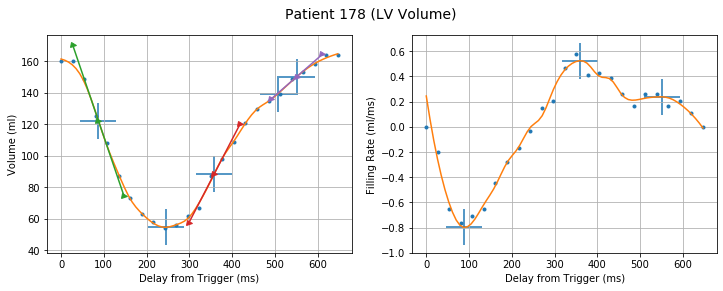

R-R interval                   = 647 ms
Time of end systole            = 245 ms
Peak LV ejection rate          = 798.854 ml/sec
Time of peak LV ejection       = 87.458 ms
Volume at peak LV ejection     = 122.287 ml
Early diastolic peak filling   = 523.507 ml/sec
Time of peak after end systole = 113.696 ms
Volume at early peak filling   = 88.669 ml
Late diastolic peak filling    = 236.911 ml/sec
Time peak after end systole    = 306.104 ms
Volume at late peak filling    = 150.180 ml
Time of 80% filling            = 507 ms
Time after systole for 80%     = 262 ms
Filling time ratio (DVR80)     = 0.652


In [7]:
plot_lv_params(patients[patientno])

Report Parameters of Atrial Curve

In [8]:
def la_es_index(volumes):
    return np.argmax(volumes)

def la_split_at_es(volumes):
    es = la_es_index(volumes)
    return volumes[:es], volumes[es:]

def la_vol_at_es(volumes):
    return volumes[la_es_index(volumes)]

def la_vol_at_es(volumes, es):
    return volumes[es]

def la_vol_at_ss(volumes):
    return volumes[0]

def la_vol_at_ed(volumes):
    return volumes[-1]

def la_idx_max_systolic_up_slope(volumes, slopes):
    esi = la_es_index(volumes)
    systolic_down_slopes = slopes[:esi]
    return systolic_down_slopes.argmax()

def la_idx_max_emptying_slopes(volumes, slopes):
    esi = la_es_index(volumes)

    # need to further split into early and late.
    idxsplit = esi + (len(volumes) - esi) // 2
    
    diastolic_early_up_slopes = -slopes[esi:idxsplit]
    diastolic_late_up_slopes = -slopes[idxsplit:]
    idx_early = diastolic_early_up_slopes.argmax() + esi
    idx_late = diastolic_late_up_slopes.argmax() + idxsplit
    
    return idx_early, idx_late


In [9]:
def plot_la_params(patient, region='LA'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 
    diffs = np.gradient(volume) / np.diff(time)[0]
    r_to_r = time[-1]
    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_msecs      = np.mean(np.diff(time))
    # one order higher for the derivative sounds right .. increase window to match
    sg_derivative = savgol_filter(x=volume, window_length=7, polyorder=3, deriv=1, mode='interp', delta=dt_msecs)

    spline = InterpolatedUnivariateSpline(time, sg_volume)
    spline_deriv = InterpolatedUnivariateSpline(time, sg_derivative)

    interpolated_time   = np.linspace(0, time[-1], len(time)*3)
    interpolated_savgol = spline(interpolated_time)
    interpolated_deriv  = spline_deriv(interpolated_time)

    max_vol_index = la_es_index(interpolated_savgol)
    max_vol_time  = interpolated_time[max_vol_index]
    max_volume    = interpolated_savgol[max_vol_index]

    max_filling_index = la_idx_max_systolic_up_slope(interpolated_savgol, interpolated_deriv)
    max_filling_time = interpolated_time[max_filling_index]
    max_filling_vol = interpolated_savgol[max_filling_index]
    max_filling_slope = interpolated_deriv[max_filling_index]
    
    max_early_emptying_index, max_late_emptying_index = la_idx_max_emptying_slopes(interpolated_savgol, interpolated_deriv)

    max_early_emptying_time = interpolated_time[max_early_emptying_index]
    max_early_emptying_vol = interpolated_savgol[max_early_emptying_index]
    max_early_emptying_slope = interpolated_deriv[max_early_emptying_index]    

    max_late_emptying_time = interpolated_time[max_late_emptying_index]
    max_late_emptying_vol = interpolated_savgol[max_late_emptying_index]
    max_late_emptying_slope = interpolated_deriv[max_late_emptying_index]    

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(time, volume, ls='None', marker='.')
    ax[0].plot(interpolated_time, interpolated_savgol, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)    
    ax[0].scatter(
        [max_filling_time, max_vol_time, max_early_emptying_time, max_late_emptying_time],
        [max_filling_vol, max_volume, max_early_emptying_vol, max_late_emptying_vol],
        s=1250, marker='+'
    )    
    plot_tangent((max_filling_time, max_filling_vol), slope=max_filling_slope, axes=ax[0])
    plot_tangent((max_early_emptying_time, max_early_emptying_vol), slope=max_early_emptying_slope, axes=ax[0])
    plot_tangent((max_late_emptying_time, max_late_emptying_vol), slope=max_late_emptying_slope, axes=ax[0])

    
    ax[1].plot(time, diffs, ls='None', marker='.')
    ax[1].plot(interpolated_time, interpolated_deriv, '-')
    ax[1].grid(True)
    ax[1].scatter(
        [max_filling_time, max_early_emptying_time, max_late_emptying_time],
        [max_filling_slope, max_early_emptying_slope, max_late_emptying_slope],
        s=1250, marker='+'
    )
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('dV/dt (%s)' % 'ml/ms')    
    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('R-R interval                   = %3.0f ms' % r_to_r)

    print('Time of end systole            = %3.0f ms' % max_vol_time)

    print('Peak LA filling rate           = %0.3f ml/sec' % (1000 *max_filling_slope))
    print('Time of peak LA filling        = %0.3f ms' % max_filling_time)
    print('Volume at peak LA filling      = %0.3f ml' % max_filling_vol)

    print('Early atrial peak emptying     = %0.3f ml/sec' % (-1000 *max_early_emptying_slope))
    print('Time of peak after end systole = %0.3f ms' % (max_early_emptying_time - max_vol_time))
    print('Volume at early peak emptying  = %0.3f ml' % max_early_emptying_vol)

    print('Late atrial peak emptying      = %0.3f ml/sec' % (-1000 *max_late_emptying_slope))
    print('Time of peak after end systole = %0.3f ms' % (max_late_emptying_time - max_vol_time))
    print('Volume at late peak emptying   = %0.3f ml' % max_late_emptying_vol)
    

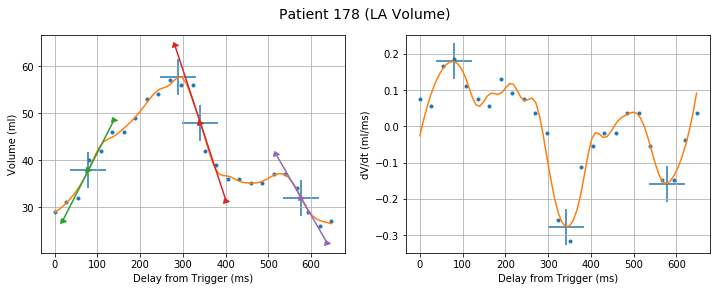

R-R interval                   = 647 ms
Time of end systole            = 289 ms
Peak LA filling rate           = 178.907 ml/sec
Time of peak LA filling        = 78.712 ms
Volume at peak LA filling      = 37.777 ml
Early atrial peak emptying     = 276.998 ml/sec
Time of peak after end systole = 52.475 ms
Volume at early peak emptying  = 47.865 ml
Late atrial peak emptying      = 158.269 ml/sec
Time of peak after end systole = 288.612 ms
Volume at late peak emptying   = 31.811 ml


In [10]:
plot_la_params(patients[patientno])

Note we are not getting the same time for end systole. It looks a little later on the LA curves. The 45ms may be the delay until the atrium starts to significantly offload into the ventricle (time for valves to open and ventricle to start relaxing?)

It wasn't clear whether we should use the ES time from LV or LA when quoting times for the emptying phase of the LA. The time resolution is pretty poor anyway. This corresponds to a single point really.

We'll use the times in the LA curve as above rather than trying to put the ES from the LV curve on the LA one.

Note that the maximum slopes in the LA curves are quite sensitive to the degree of filtering. We have chosen to increase the order by one in calculating the derivative and widened the window at the same time. It's not clear whether there is an entirely principled way to choose these smoothing parameters.

There is also the issue of what volume we take to be the full one in the ventricular curve - the initial or final one. We have chosen the initial volume but have left open the possibility of using an average of the initial and final. This will effect the DVR(80%) time.

----